# Sensitivity check for calculation of AAD from hazard return period maps

In this code, we (qualitatively) examine how sensitive the estimation of annual average displacement (AAD) values are (impact.aai_agg) depending on which hazard RP maps that were included. We perform the analysis for floods in 2 countries (PHL, SOM)

In [1]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard

# select country here
cntry = 'Somalia'

In [2]:
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_FL'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_FLIMPF_CIMA[row.se_seismo], axis=1)

for col in ['iso3', 'sector', 'valfis']:
    gdf_bem_subcomps.pop(col)

exp = Exposures(gdf_bem_subcomps)
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf = exp.gdf[~np.isnan(
    exp.gdf.latitude)]  # drop nan centroids

### Load CIMA flood hazard (river)

In [3]:
HAZ_FOLDER = Path(f'/cluster/work/climate/evelynm/IDMC_UNU/hazard/flood_HM_CIMA/{cntry}/HISTORICAL/')
HAZ_TYPE = 'FL'

haz_files = np.sort([str(file) for file in HAZ_FOLDER.glob('*.tif')])
rp = np.sort(np.array([int(Path(file).stem[-4:]) for file in haz_files]))

Create a dictionary (haz_dict) where each key is a number from 1 to 9 (representing the count of RPs and files) and each value is a Hazard object created using progressively more elements from haz_files and rp up to that number.

In [4]:
haz_dict = {}
for i in range(1, 10):
    files_slice = haz_files[:i]
    rp_slice = rp[:i]

    # Create the Hazard object
    haz = Hazard.from_raster(
        haz_type=HAZ_TYPE,
        files_intensity=list(files_slice),
        src_crs='WGS84',
        attrs={
            'unit': 'm',
            'event_id': np.arange(len(files_slice)),
            'frequency': 1 / rp_slice
        }
    )
    haz.intensity = haz.intensity/100
    haz_dict[i] = haz

### Caluclate impacts

#### CIMA/Capra impact functions

In [5]:
impf_set_cima = vulnerability.IMPF_SET_FL_CIMA

In [6]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_cima_step = ImpactFuncSet()

In [7]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.3 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_cima.get_ids(haz_type='FL'):
    impf_set_cima.get_func(fun_id=imp_id)
    y = impf_set_cima.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_cima.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    impf_set_cima_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

In [8]:
aai_agg_dict = {}
for n, haz in haz_dict.items():
    impact = ImpactCalc(exp, impf_set_cima_step, haz).impact()
    aai_agg_dict[n] = impact.aai_agg

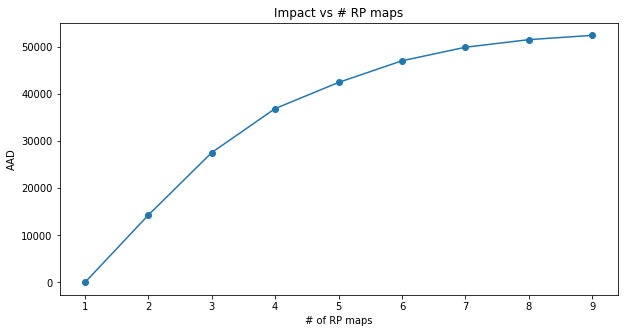

In [9]:
import matplotlib.pyplot as plt

RPs = list(aai_agg_dict.keys())
impacts = list(aai_agg_dict.values())

plt.figure(figsize=(10, 5))
plt.plot(RPs, impacts, marker='o')
plt.title('Impact vs # RP maps')
plt.xlabel('# of RP maps')
plt.ylabel('AAD')
plt.show()

In [10]:
aai_agg_dict

{1: 0.0,
 2: 14307.27784673741,
 3: 27588.561086471127,
 4: 36933.87399063758,
 5: 42486.14860083056,
 6: 47081.49006567723,
 7: 49961.74650385818,
 8: 51569.828748638,
 9: 52485.36424177725}

In [11]:
imp = []
for n in range(0,9):
    imp.append(impact.at_event[n]*impact.frequency[n])

In [12]:
imp

[0.0,
 14307.277846737408,
 13281.283239733719,
 9345.312904166463,
 5552.274610192963,
 4595.34146484671,
 2880.2564381808693,
 1608.0822447799073,
 915.5354931392578]

In [13]:
sum(imp)

52485.3642417773

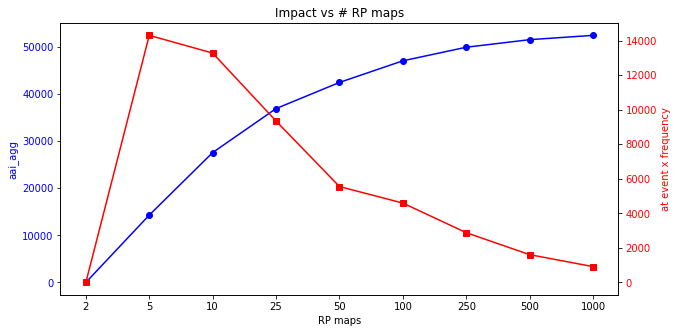

In [14]:
plt.figure(figsize=(10, 5))

ax1 = plt.gca() 
ax1.plot(RPs, impacts, marker='o', color='b')
ax1.set_xlabel('RP maps')
ax1.set_ylabel('aai_agg', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax1.set_xticks(RPs)
ax1.set_xticklabels(rp)

ax2 = ax1.twinx()
ax2.plot(RPs, imp, marker='s', color='r')
ax2.set_ylabel('at event x frequency', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Impact vs # RP maps')
fig = plt.gcf()

plt.show()

### TC RP maps

In [15]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard

# select country here
cntry = 'Philippines'

In [16]:
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_TC'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_TCIMPF_HAZUS[row.se_seismo], axis=1)

for col in ['iso3', 'sector', 'valfis']:
    gdf_bem_subcomps.pop(col)

exp = Exposures(gdf_bem_subcomps)
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf = exp.gdf[~np.isnan(
    exp.gdf.latitude)]  # drop nan centroids

In [17]:
# load TC hazard phl
if cntry == 'Somalia':
    reg = 'IO'
elif cntry == 'Philippines':
    reg = 'WP'
else:
    reg = print('no country-basin assingment found')

haz_TC_dir = Path('/cluster/work/climate/meilers/climada/data/hazard/RPmaps')
haz_str= f'TC_{reg}_0150as_MIT_RP-maps.nc'

In [18]:
import xarray as xr
from scipy import sparse
from climada.hazard.centroids.centr import Centroids

def read_netcdf_as_hazard(file_path):
    """
    Read NetCDF file containing exceedance intensity data for various return periods
    and convert it into a Hazard object.

    Args:
    - file_path (str): Path to the NetCDF file.

    Returns:
    - Hazard: Hazard object containing the data from the NetCDF file.
    """
    with xr.open_dataset(file_path) as ds:
        centroids = Centroids(lat=ds['latitude'].values, lon=ds['longitude'].values)
        
        # Create a list to hold intensity data arrays
        intensity_arrays = []
        return_periods = [1, 10, 25, 50, 100, 250]  # Specify your return periods
        for rp in return_periods:
            intensity_var = f'intensity_RP{rp}'
            intensity_arrays.append(ds[intensity_var].values)

        # Stack arrays vertically and convert to sparse matrix
        intensity_matrix = np.vstack(intensity_arrays)
        intensity_sparse = sparse.csr_matrix(intensity_matrix)

        # Create the Hazard object
        hazard = Hazard(
            haz_type='TC',
            units='m/s',
            centroids=centroids,
            event_id=np.arange(len(np.array(return_periods, dtype=int))),
            event_name=np.arange(len(np.array(return_periods, dtype=int))),
            date=np.arange(len(np.array(return_periods, dtype=int))),
            intensity=intensity_sparse,
            frequency=1 / np.array(return_periods)
        )

    return hazard

In [19]:
file_path = haz_TC_dir.joinpath(haz_str)
RP_haz = read_netcdf_as_hazard(file_path)

In [20]:
impf_set_tc = vulnerability.IMPF_SET_TC_HAZUS

impf_set_tc_step = ImpactFuncSet()

In [21]:
building_thresh = 0.55 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_tc.get_ids(haz_type='TC'):
    impf_set_tc.get_func(fun_id=imp_id)
    y = impf_set_tc.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_tc.get_func(fun_id=imp_id)[0].mdd
    thresh = np.interp(building_thresh, x, y)
    impf_set_tc_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  thresh, thresh *10),
                    haz_type='TC',
                    impf_id=imp_id,
                    intensity_unit = 'm/s'
                )
    )

In [22]:
impcalc = ImpactCalc(exp, impf_set_tc_step, RP_haz)
impact = impcalc.impact()

In [23]:
impTC = []
impTCcumsum = []
for n in range(0,6):
    impTC.append(impact.at_event[n]*impact.frequency[n])
    impTCcumsum = np.cumsum(impTC)

In [24]:
impTC

[0.0,
 1371268.1481255915,
 1187950.7528992584,
 685582.9092129825,
 430980.07548440056,
 336134.28079056524]

In [25]:
impTCcumsum

array([      0.        , 1371268.14812559, 2559218.90102485,
       3244801.81023783, 3675781.88572223, 4011916.1665128 ])

### comparison to event-based TC impact calculation

In [26]:
hazard_dir = SYSTEM_DIR/"hazard"/"present"

In [27]:
if cntry == 'Somalia':
    reg = 'IO'
elif cntry == 'Philippines':
    reg = 'WP'
else:
    reg = print('no country-basin assingment found')

tc_haz = TropCyclone.from_hdf5(hazard_dir.joinpath(f'TC_{reg}_0150as_MIT_H08.hdf5'))

In [28]:
impcalc = ImpactCalc(exp, impf_set_tc_step, tc_haz)
impact = impcalc.impact()

In [29]:
print(impact.aai_agg)

3297510.6990920543


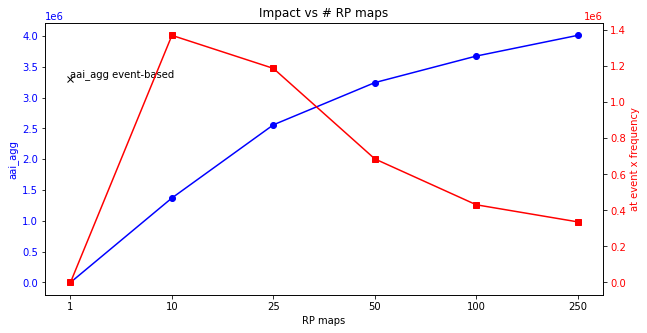

In [30]:
return_periods = [1, 10, 25, 50, 100, 250]
RPs = np.arange(0,6)

plt.figure(figsize=(10, 5))

ax1 = plt.gca()
ax1.plot(RPs, impTCcumsum, marker='o', color='b')
ax1.set_xlabel('RP maps')
ax1.set_ylabel('aai_agg', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.plot(0, impact.aai_agg, marker='x', color='k')
ax1.text(0, impact.aai_agg, 'aai_agg event-based', color='k', verticalalignment='bottom')

ax1.set_xticks(RPs)
ax1.set_xticklabels(return_periods)

ax2 = ax1.twinx()
ax2.plot(RPs, impTC, marker='s', color='r')
ax2.set_ylabel('at event x frequency', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Impact vs # RP maps')
fig = plt.gcf()

plt.show()